In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


Epoch [1/20] Train Loss: 1.1878 | Train Acc: 51.92% | Val Loss: 1.0450 | Val Acc: 57.00% | Val Kappa: 0.6933
Epoch [2/20] Train Loss: 0.8195 | Train Acc: 67.92% | Val Loss: 1.0630 | Val Acc: 60.50% | Val Kappa: 0.7455
Epoch [3/20] Train Loss: 0.6452 | Train Acc: 75.67% | Val Loss: 1.2384 | Val Acc: 57.50% | Val Kappa: 0.6811
Epoch [4/20] Train Loss: 0.5726 | Train Acc: 79.00% | Val Loss: 1.0285 | Val Acc: 64.75% | Val Kappa: 0.7914
Epoch [5/20] Train Loss: 0.4655 | Train Acc: 84.00% | Val Loss: 1.1343 | Val Acc: 61.50% | Val Kappa: 0.7564
Epoch [6/20] Train Loss: 0.4221 | Train Acc: 85.08% | Val Loss: 1.2124 | Val Acc: 59.75% | Val Kappa: 0.7222
Epoch [7/20] Train Loss: 0.3356 | Train Acc: 88.17% | Val Loss: 1.2387 | Val Acc: 64.25% | Val Kappa: 0.7806
Epoch [8/20] Train Loss: 0.3161 | Train Acc: 88.67% | Val Loss: 1.1446 | Val Acc: 62.00% | Val Kappa: 0.7701
Epoch [9/20] Train Loss: 0.2476 | Train Acc: 91.17% | Val Loss: 1.3314 | Val Acc: 63.50% | Val Kappa: 0.7706
Epoch [10/20] Train

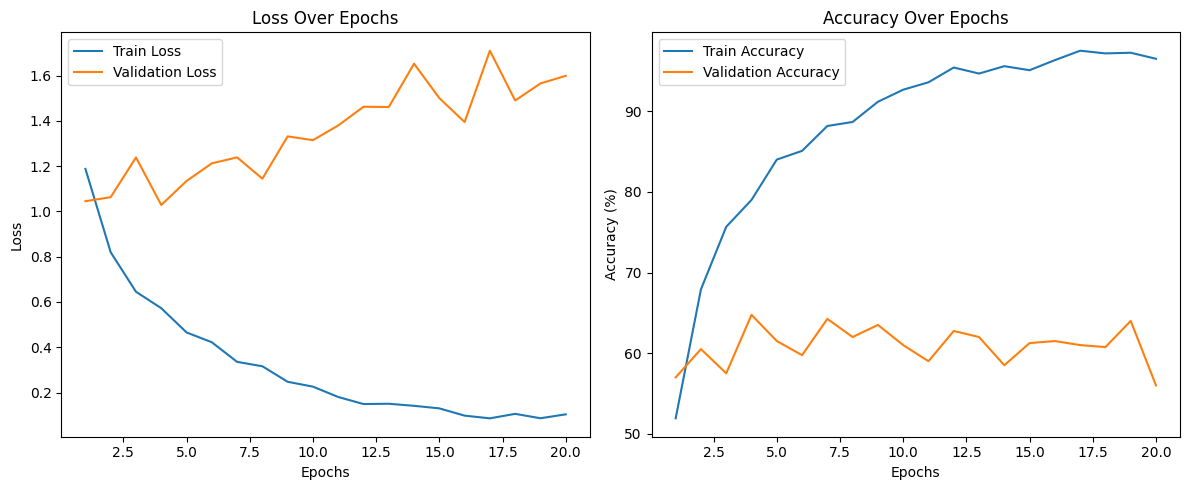

<ipython-input-2-c24aa2e243b9>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


ValueError: All arrays must be of the same length

In [ ]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image, ImageDraw, ImageOps
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 24
num_classes = 5
learning_rate = 0.0001
num_epochs = 20

# Preprocessing Options
USE_CIRCLE_CROPPING = True
USE_CLAHE = False

# Ben Graham's Circular Cropping Function
def circular_crop(img):
    w, h = img.size
    mask = Image.new('L', (w, h), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, w, h), fill=255)
    result = Image.new('RGB', (w, h))
    result.paste(img, (0, 0), mask=mask)
    return result

# CLAHE Function
def apply_clahe(img):
    img_gray = ImageOps.grayscale(img)
    img_array = np.array(img_gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_array)
    return Image.fromarray(img_clahe).convert('RGB')

# Dataset Class with Optional Preprocessing
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, test=False):
        self.data = pd.read_csv(ann_file)
        self.image_dir = image_dir
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        img_path = os.path.join(self.image_dir, row['img_path'])
        img = Image.open(img_path).convert('RGB')

        if USE_CIRCLE_CROPPING:
            img = circular_crop(img)

        if USE_CLAHE:
            img = apply_clahe(img)

        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(row['patient_DR_Level'], dtype=torch.long)
            return img, label
        else:
            return img

# Transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define Model
class MyModel(nn.Module):
    def __init__(self, num_classes=5):
        super(MyModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100. * correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history

# Evaluation Function
def evaluate_model(model, loader, criterion, device):
    model.eval()
    loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    loss /= len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy

# Visualization Function
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train/', transform_train)
    val_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val/', transform_test)
    test_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/', transform_test, test=True)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MyModel(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    plot_history(history)

    # Test Prediction and Save
    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            image_ids.extend(test_loader.dataset.data['img_path'])

    submission = pd.DataFrame({'ID': image_ids, 'TARGET': predictions})
    submission.to_csv('submission.csv', index=False)
    print('Submission file saved as submission.csv')

if __name__ == '__main__':
    main()


In [ ]:
# Ensure the same model architecture as used during training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel(num_classes=num_classes).to(device)
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BenGraham_best_model.pth'


# Load the best model weights
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Initialize variables for predictions and image IDs
predictions = []
image_ids = []
test_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/', transform_test, test=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Perform predictions on the test dataset
with torch.no_grad():
    for i, images in enumerate(test_loader): # Use enumerate to access the batch index
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        predictions.extend(predicted.cpu().numpy())

        batch_image_ids = test_loader.dataset.data['img_path'][i * batch_size : (i + 1) * batch_size].tolist()

        image_ids.extend([os.path.basename(path) for path in batch_image_ids])

# Create and save the submission file
submission = pd.DataFrame({'ID': image_ids, 'TARGET': predictions})
submission_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BenGraham_submission.csv'
submission.to_csv(submission_path, index=False)
print(f'Submission file saved at {submission_path}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-10-1456119657aa>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Submission file saved at /content/drive/MyDrive/Colab Notebooks/dataset/BenGraham_submission.csv


In [ ]:
def generate_gradcam(model, image, target_layer, device):
    model.eval()

    image = image.to(device)

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_backward_hook(backward_hook)

    output = model(image)
    target_class = torch.argmax(output, dim=1)
    loss = output[0, target_class]
    loss.backward()

    handle1.remove()
    handle2.remove()

    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-14-b7c282e8757e>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

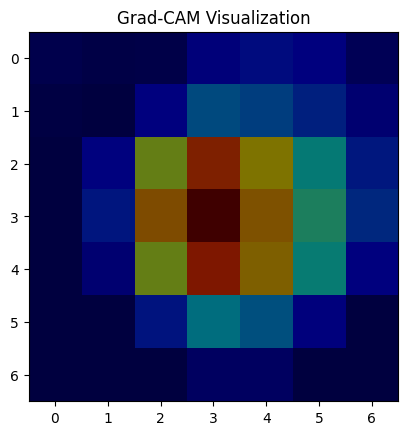

In [ ]:
# Load and preprocess the image
image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/release/DeepDRiD/val/402/402_l1.jpg'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#input_tensor = transform(image).unsqueeze(0) # This line was causing the error.
input_tensor = transform(image).unsqueeze(0)  # Adding batch dimension here if needed


# Load your trained model
model = MyModel(num_classes=5)  # Correctly pass num_classes and backbone
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dataset/BenGraham_best_model.pth'))
model.eval()


target_layer = model.backbone.layer4[-1]


cam = generate_gradcam(model, input_tensor, target_layer, device='cpu')

# Visualize the result
plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Visualization")
plt.show()

In [ ]:
!pip install opencv-python
#import cv2 #

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=47beda968b6cf682cd4a099400b022f8a94e9516b1af1dcce32fbf86e93a87b5
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

def apply_gradcam(model, img_path, target_layer, output_path):
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform_test(image).unsqueeze(0).to(device)

    # Access layer4 through model.backbone
    cam = GradCAM(model=model, target_layers=[model.backbone.layer4[-1]])
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]

    # Resize grayscale_cam to match the image dimensions
    grayscale_cam = cv2.resize(grayscale_cam, (image.size[0], image.size[1]))

    visualization = show_cam_on_image(np.array(image) / 255.0, grayscale_cam, use_rgb=True)

    # Display the original image
    plt.figure() # Create a new figure
    plt.imshow(image)
    plt.title("Original Image")
    plt.show()

    # Display the Grad-CAM visualization
    plt.figure() # Create another figure for Grad-CAM
    plt.imshow(visualization)
    plt.title("Grad-CAM Visualization")
    plt.show()

    # Save the visualization to the specified path
    plt.imsave(output_path, visualization)
    print(f"Grad-CAM visualization saved to: {output_path}")

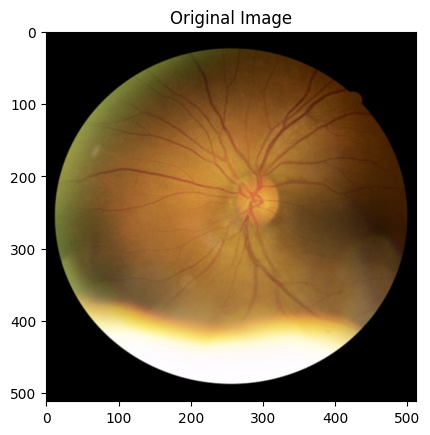

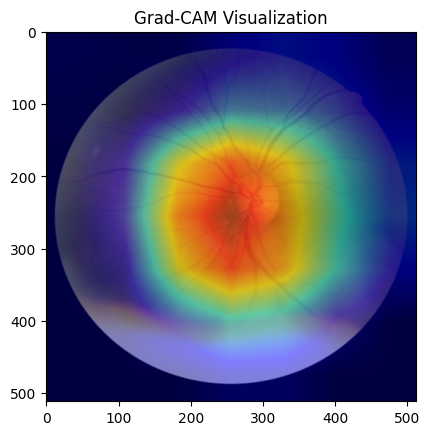

Grad-CAM visualization saved to: /content/drive/MyDrive/Colab Notebooks/dataset/BenGraham_visualization_efficient_1.jpg


In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/release/DeepDRiD/val/402/402_l1.jpg'
output_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BenGraham_visualization_efficient_1.jpg' # Choose your output path
apply_gradcam(model, image_path, target_layer=[model.backbone.layer4[-1]], output_path=output_path)